In [1]:
import numpy as np
import os
import segyio

from pyfrac.visualisation.plotting_support import explode_volume
from pyfrac.visualisation.traceviz import wiggleplot

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# expname = 'homoRB'
# projpath = '../../FDModelling/HomoLabRockBlock/'

# expname = 'StylolitesTest_pointrecs'
# projpath = '../../FDModelling/StylolitesTest_pointrecs/'

expname = 'StylolitesTest_pointrecs_v80_3mm'
projpath = '../../FDModelling/StylolitesTest_pointrecs_v80_3mm/'

# expname = 'StySamp'
# projpath = '/home/birniece/Documents/Projects/MicroseismicModelling/MicroseismicProcessing/FDModelling/StylolitesSample'

snappath = os.path.join(projpath,'outputs/snap/')
seispath = os.path.join(projpath,'outputs/su/')

outpath = './StylolitesData/'

In [3]:
nbounds = abs_bounds = 30 # boundary points

dx = dy = dz = 0.001  # 5mm
dimlims = 0.4 + 2*(abs_bounds*dx) # 40cm cubed
nx = ny = nz = int(dimlims/dx) 
print(nx)

nr = 150
snap_sbsmp = 10

460


# SNAPS

In [4]:
def read_snap(snap_file, modshape, snap_sbsmp=1, nbounds=0., freesurface=False):
    '''modshape = [nx,ny,nz]
    '''
    # Read in snaps file
    snaps_1d = np.fromfile(snap_file, dtype='<f')

    # Get snap dimensions
    snap_nx = int(modshape[0] / snap_sbsmp)
    snap_ny = int(modshape[1] / snap_sbsmp)
    snap_nz = int(modshape[2] / snap_sbsmp)
    nsnaps = int(snaps_1d.shape[0] / (snap_nx * snap_ny * snap_nz))

    snaps_4d = snaps_1d.reshape([nsnaps, snap_nz, snap_nx, snap_ny, ])
    snaps_4d = np.transpose(snaps_4d, [0, 3, 1, 2])

    if np.float64(nbounds) == 0.:
        return snaps_4d
    else:
        bounds_shift = int(nbounds / snap_sbsmp)
        if not freesurface:
            snaps_4d_excbounds = snaps_4d[:,
                                 bounds_shift:-bounds_shift,
                                 bounds_shift:-bounds_shift,
                                 bounds_shift:-bounds_shift]
        else:
            snaps_4d_excbounds = snaps_4d[:,
                                 :-bounds_shift,
                                 bounds_shift:-bounds_shift,
                                 bounds_shift:-bounds_shift]
        return snaps_4d, snaps_4d_excbounds
    

In [5]:

snap_file = os.path.join(snappath,'%s.bin.div'%expname)

snaps_4d, snaps_4d_excbounds = read_snap(snap_file, 
                                         modshape = [nx, ny, nz], 
                                         snap_sbsmp=snap_sbsmp, 
                                         nbounds=nbounds, 
                                         freesurface=False)

print(snaps_4d.shape)
print(snaps_4d_excbounds.shape)

print(np.unravel_index(np.argmax(snaps_4d),snaps_4d.shape))
print(np.unravel_index(np.argmax(snaps_4d_excbounds),snaps_4d_excbounds.shape))

(1901, 46, 46, 46)
(1901, 40, 40, 40)
(43, 23, 23, 23)
(43, 20, 20, 20)


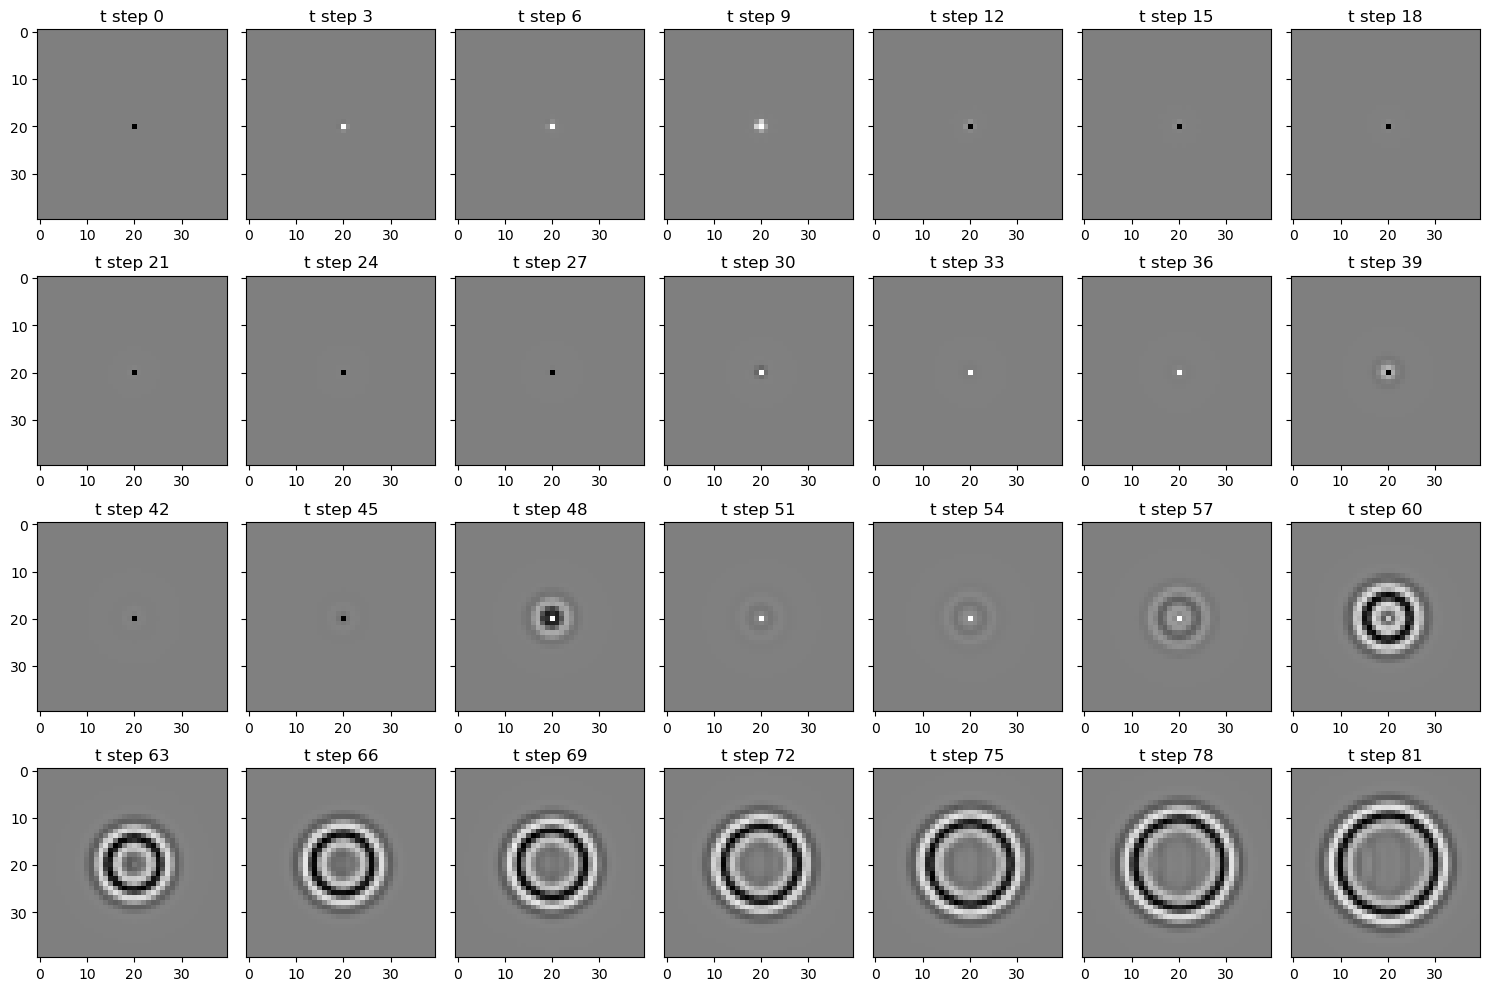

In [6]:
fig,axs = plt.subplots(4,7, figsize=[15,10], sharey=True)
for i,ax in enumerate(axs.ravel()):
    snap = snaps_4d_excbounds[i*3,:,20,:]
    ax.imshow(snap/np.max(abs(snap)),  
                          cmap='binary', vmin=-1, vmax=1, 
                         )
    ax.set_title('t step %i'%(i*3))
# for ax in axs.ravel(): ax.set_yticks([]); ax.set_xticks([])
plt.tight_layout()

(<Figure size 800x800 with 3 Axes>,
 (<Axes: xlabel='x samples', ylabel='t samples'>,
  <Axes: xlabel='y samples'>,
  <Axes: ylabel='y samples'>))

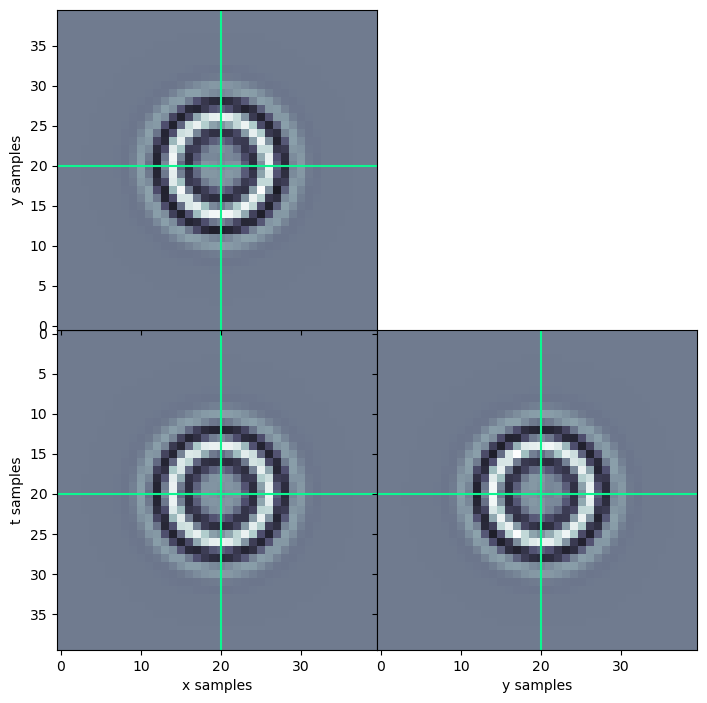

In [7]:
explode_volume(snaps_4d_excbounds[65], p=99.99999999, x=20, t=20, y=20)

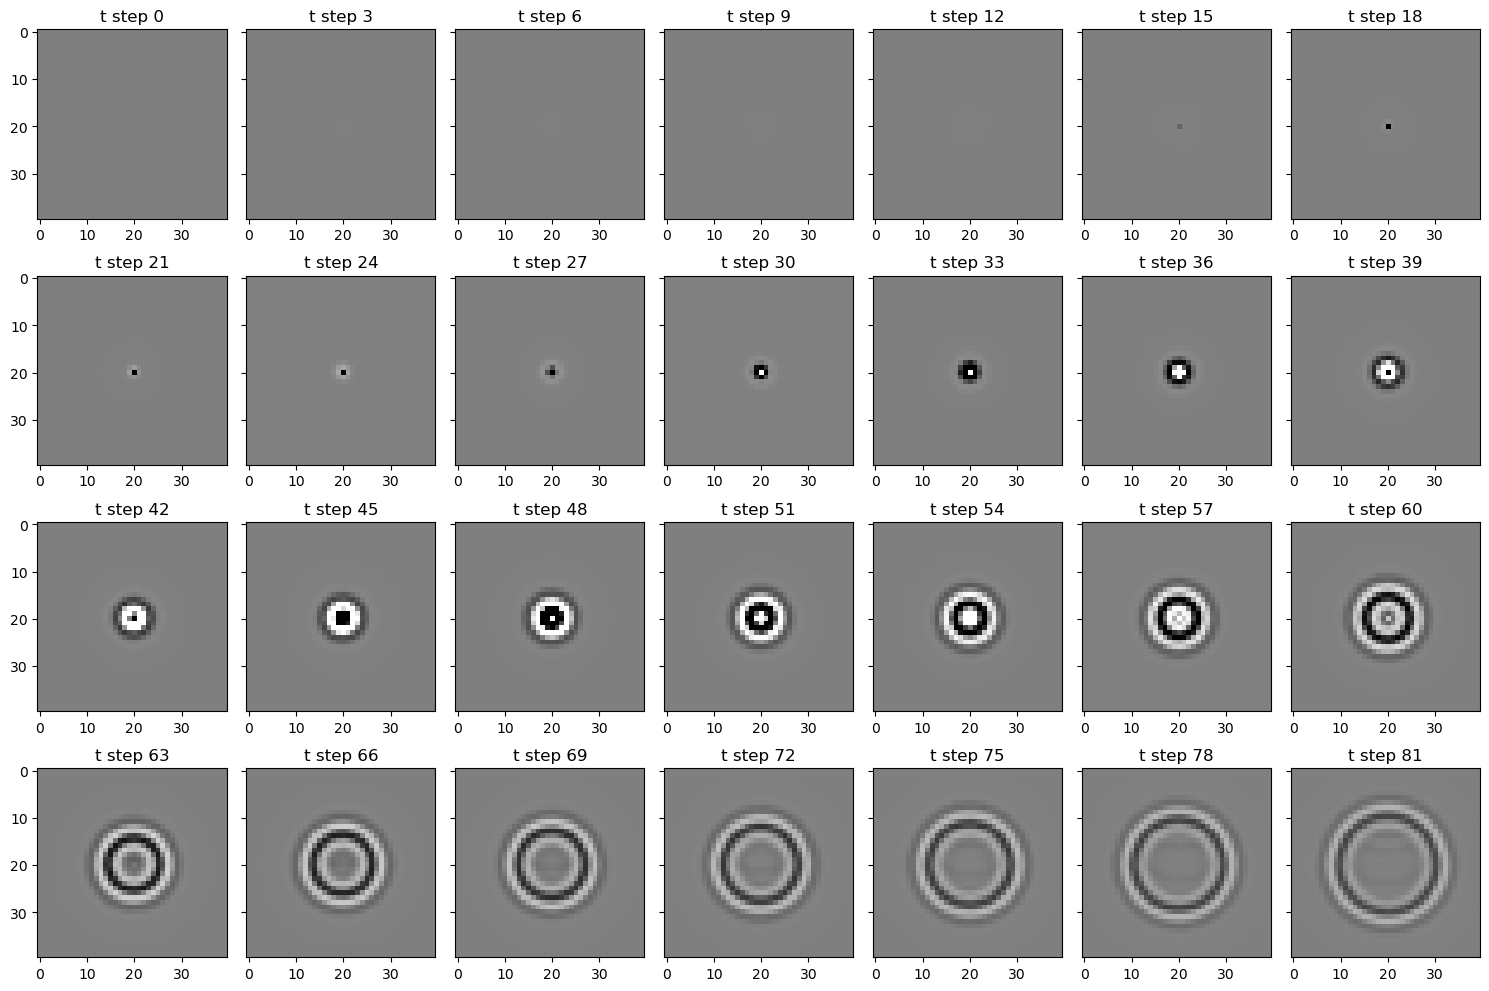

In [8]:
fig,axs = plt.subplots(4,7, figsize=[15,10], sharey=True)
for i,ax in enumerate(axs.ravel()):
    snap = snaps_4d_excbounds[i*3,:,20,:]
    ax.imshow(snap.T/np.max(abs(snaps_4d_excbounds)),  
                          cmap='binary', vmin=-0.01, vmax=0.01, 
                         )
    ax.set_title('t step %i'%(i*3))
# for ax in axs.ravel(): ax.set_yticks([]); ax.set_xticks([])
plt.tight_layout()

# Receivers

In [9]:
def read_seis(seisfile, nr):
    # s_wave_file = os.path.join(data_path,'test.bin.curl')
    seis_flat = np.loadtxt(seisfile, delimiter="\n")

    # determine number of timesamples and ensure it saved fully
    nt = int(seis_flat.shape[0] / nr)
    try:
        seis_flat.reshape((nr, nt))
    except:
        print('Not good dims \n nt:%i nr:%i \n vz flat:%i' % (nt, nr, seis_flat.shape[0]))

    # Resample to 2D
    seis = seis_flat[:nt * nr].reshape((nr, nt))
    return seis

In [10]:
p = read_seis(os.path.join(seispath,'%s_div.txt'%expname), nr)
vx = read_seis(os.path.join(seispath,'%s_vx.txt'%expname), nr)
vy = read_seis(os.path.join(seispath,'%s_vy.txt'%expname), nr)
vz = read_seis(os.path.join(seispath,'%s_vz.txt'%expname), nr)



In [11]:
vx.shape

(150, 1000)

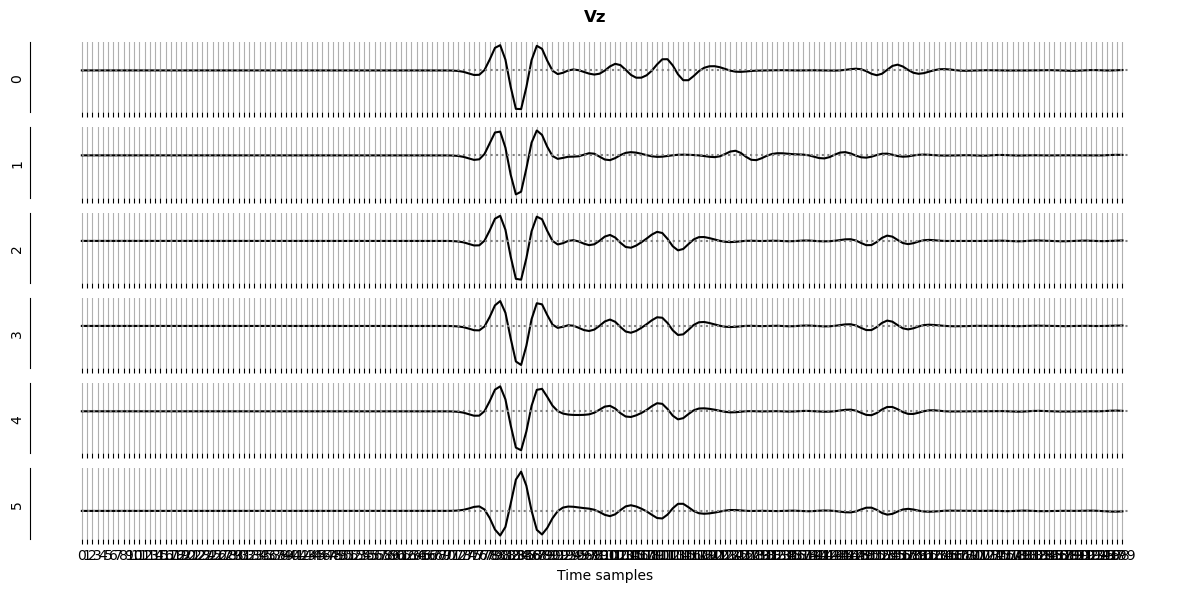

In [12]:
fig,axs = wiggleplot(vz[::25,:200]);
fig.suptitle('Vz', fontweight='bold')
plt.tight_layout()

# SAVE DATA

In [13]:
mod_path = os.path.join(projpath,'inputs/model/')

vp_mod = np.fromfile(os.path.join(mod_path,'%s.vp'%expname), dtype='<f').reshape([nz, nx, ny])[nbounds:-nbounds,nbounds:-nbounds,nbounds:-nbounds]
vs_mod = np.fromfile(os.path.join(mod_path,'%s.vp'%expname), dtype='<f').reshape([nz, nx, ny])[nbounds:-nbounds,nbounds:-nbounds,nbounds:-nbounds]
rho_mod = np.fromfile(os.path.join(mod_path,'%s.vp'%expname), dtype='<f').reshape([nz, nx, ny])[nbounds:-nbounds,nbounds:-nbounds,nbounds:-nbounds]


vp_mod.shape

recs = np.loadtxt(os.path.join(projpath,'inputs/receiver.dat')).T
recs = recs - (nbounds*dx)

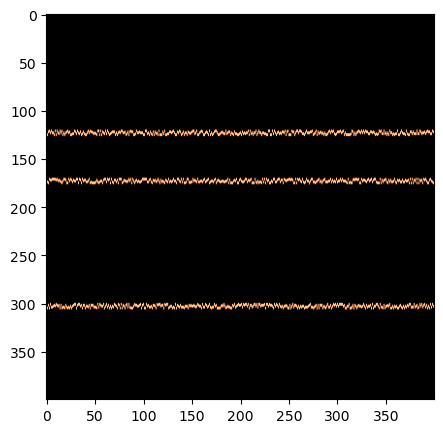

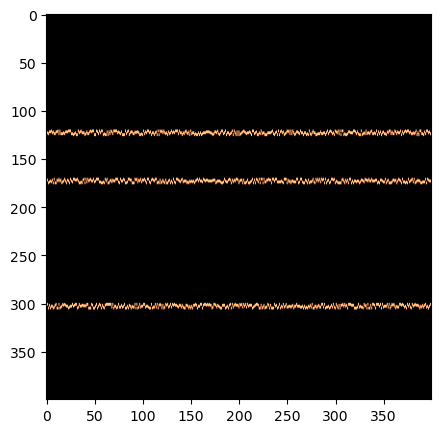

In [14]:
fig,ax = plt.subplots(1,1,figsize=[5,5])
c = ax.imshow(vp_mod[:,:,0].T, aspect='auto', cmap='copper_r')
fig,ax = plt.subplots(1,1,figsize=[5,5])
c = ax.imshow(vp_mod[0,:,:], cmap='copper_r')

In [15]:
np.savez(os.path.join(outpath,'StylolitesExp_3mm_5r_3sty_80perc.npz'),
         p = p[:,:200],
         vx = vx[:,:200],
         vy = vy[:,:200],
         vz = vz[:,:200],
         p_snaps = snaps_4d_excbounds,
         vp_mod = vp_mod,
         vs_mod = vs_mod,
         rho_mod = rho_mod,
         recs = recs
        )

In [16]:
vz.shape

(150, 1000)

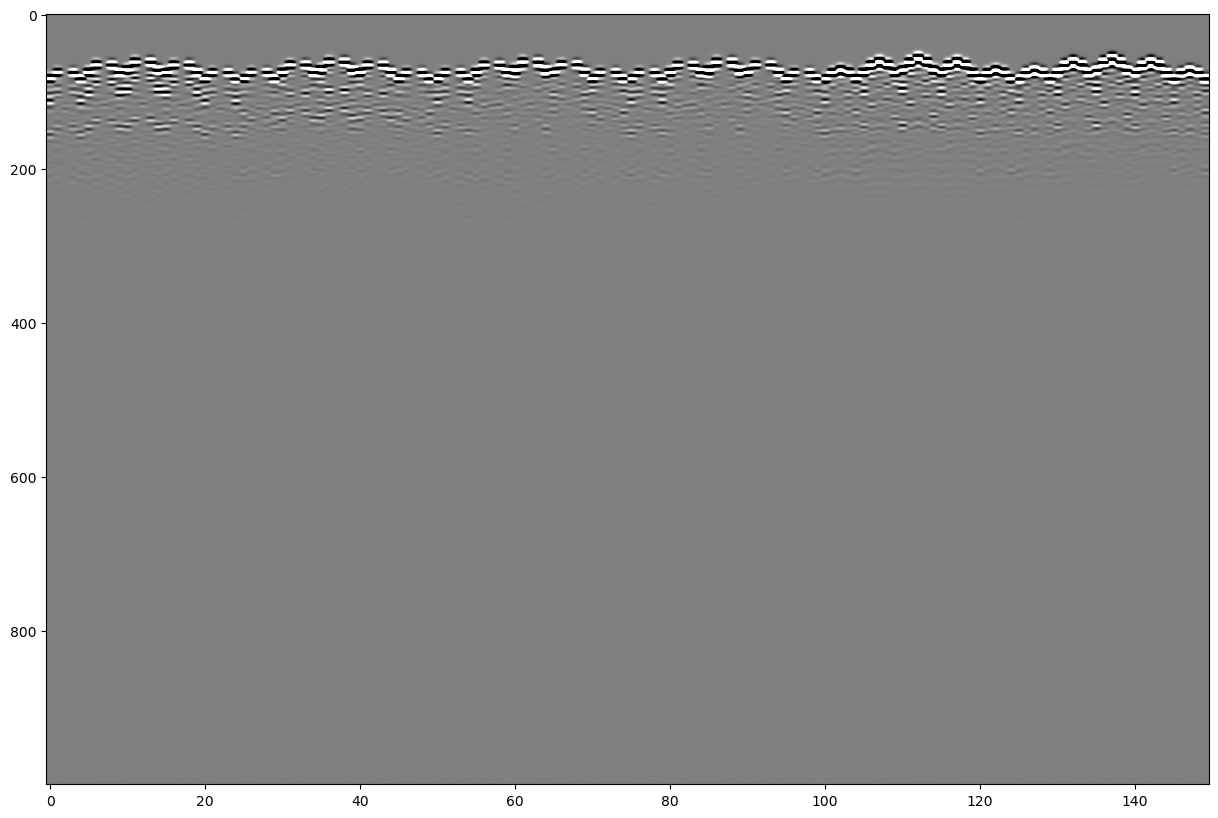

In [17]:
seislim = np.percentile(abs(vz[:6500]),99.)
vmin=-1*seislim
vmax=seislim    
cmap='binary'
              
plt.figure(figsize=[15,10])
plt.imshow(vz.T, aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax, interpolation=None)

/home/birniece/Documents/Projects/MicroseismicModelling/MicroseismicProcessing/pyfrac/visualisation/traceviz.py:10: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(data[i] / np.max(abs(data[i])), 'k');
/home/birniece/Documents/Projects/MicroseismicModelling/MicroseismicProcessing/pyfrac/visualisation/traceviz.py:26: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()
/tmp/ipykernel_9633/1531916570.py:3: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


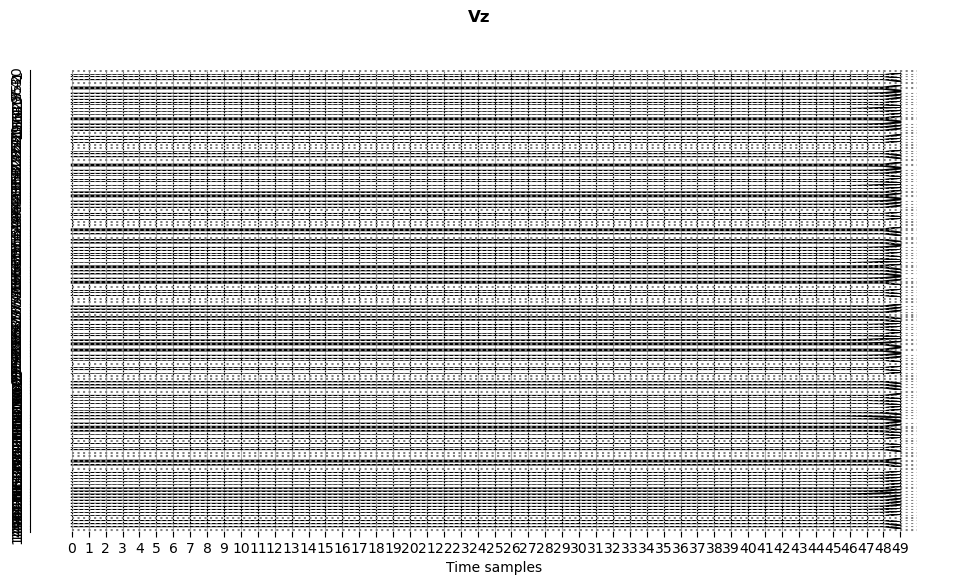

In [18]:
fig,axs = wiggleplot(vz[:,:50]);
fig.suptitle('Vz', fontweight='bold')
plt.tight_layout()